<a href="https://colab.research.google.com/github/thomascerbelaud/M2-IPE-data-energy/blob/main/notebooks/5_1_Regression_Model_Training_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 5.1: Regression model training

## Predicting building energy loads

### Dataset Information

This dataset was crafted using building energy simulations of a very simple building, with different parameters described by parameters $X_1, .., X_8$. For each simulation, the total cooling and heating loads were reported (no units available / found online...).

> "We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer."

### Variable description

| Variable | Name | Role | Type | Description | Units | Missing Values |
| :------- | :--- | :--- | :--- | :---------- | :---- | :------------- |
| X1       | Feature | Continuous | Relative Compactness |  %   |       | no             |
| X2       | Feature | Continuous | Surface Area |   m²  |       | no             |
| X3       | Feature | Continuous | Wall Area |   m²  |       | no             |
| X4       | Feature | Continuous | Roof Area |  m²   |       | no             |
| X5       | Feature | Continuous | Overall Height |   m  |       | no             |
| X6       | Feature | Integer | Orientation |  2:North, 3:East, 4:South, 5:West   |       | no             |
| X7       | Feature | Continuous | Glazing Area |  0%, 10%, 25%, 40% (of floor area)   |       | no             |
| X8       | Feature | Integer | Glazing Area Distribution |   1:Uniform, 2:North, 3:East, 4:South, 5:West  |       | no             |
| Y1       | Target | Continuous | Heating Load |  kWh / m²   |       | no             |
| Y2       | Target | Continuous | Cooling Load |  kWh / m²   |       | no             |

> *Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools*
By A. Tsanas, Angeliki Xifara. 2012, Published in Energy and Buildings, vol. 49

## Load data

In [ ]:
import io
import glob
import os
import shutil
import tempfile
import tqdm

import pandas as pd
from urllib.request import urlretrieve


def load_file_from_url(url: str) -> pd.DataFrame:
  with tempfile.TemporaryDirectory() as tempdir:
    # download
    zip_path = os.path.join(tempdir, "file.zip")
    urlretrieve(url, zip_path)

    # unpack and delete source
    shutil.unpack_archive(zip_path, tempdir)
    os.remove(zip_path)

    # load file
    filename = glob.glob(f"{tempdir}/*.xlsx")[0]
    df = pd.read_excel(filename)

  return df


# df = load_files_from_url_list(urls)
df = load_file_from_url("https://archive.ics.uci.edu/static/public/242/energy+efficiency.zip")

In [ ]:
df.columns, df.shape

(Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'], dtype='object'),
 (768, 10))

Uncomment to visualize the dataset distribution.

In [ ]:
# import seaborn as sns

# sns.pairplot(df);

## Train predictors

We are going to train three types of regressors:

* Linear regressor
* Random forest regressor
* Gradient boosting machine regressor

Regarding the linear models, we will describe a way of treating categorical variables in regression called *one hot encoding*. It consists in transforming a column of $K$ categories into a matrix with $K$ columns "one hot encoded", as described below. To make this transformation, pandas `pd.get_dummies` method can be used, as well as scikit learn preprocessing class `sklearn.preprocessing.OneHotEncoder`.

![https://miro.medium.com/v2/resize:fit:1400/format:webp/0*T5jaa2othYfXZX9W.](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*T5jaa2othYfXZX9W.)

See [scikit-learn user guide](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features) for more information.

In [ ]:
# TODO: split the data frame into the continuous, categorical and response variables
X_continuous = df[["X1", "X2", "X3", "X4", "X5", "X7"]]
X_categorical = df[["X6", "X8"]]
y = df[["Y1", "Y2"]]

In [ ]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data into train and test set
(
    X_train_continuous,
    X_test_continuous,
    X_train_categorical,
    X_test_categorical,
    y_train,
    y_test,
) = train_test_split(X_continuous, X_categorical, y, test_size=0.25, random_state=42)

# scale continuous data
scaler = StandardScaler().fit(X_train_continuous)
X_train_continuous_scaled = scaler.transform(X_train_continuous)
# TODO: scale X_test_continuous
X_test_continuous_scaled = X_test_continuous

# one hot encoding of categorical variables
categorical_columns = X_train_categorical.columns
X_train_categorical_one_hot = pd.get_dummies(X_train_categorical, columns=categorical_columns)
# TODO: one hot X_test_categorical
X_test_categorical_one_hot = pd.get_dummies(X_test_categorical, columns=categorical_columns)

# dataset without one hot encoding
X_train = np.concatenate([X_train_continuous, X_train_categorical], axis=1)
X_test = np.concatenate([X_test_continuous, X_test_categorical], axis=1)

# dataset with one hot encoding
X_train_with_one_hot = np.concatenate([X_train_continuous_scaled, X_train_categorical_one_hot], axis=1)
X_test_with_one_hot = np.concatenate([X_test_continuous_scaled, X_test_categorical_one_hot], axis=1)



Number of principal components: 6
Cumulative explained variance ratio: 1.00


<Axes: >

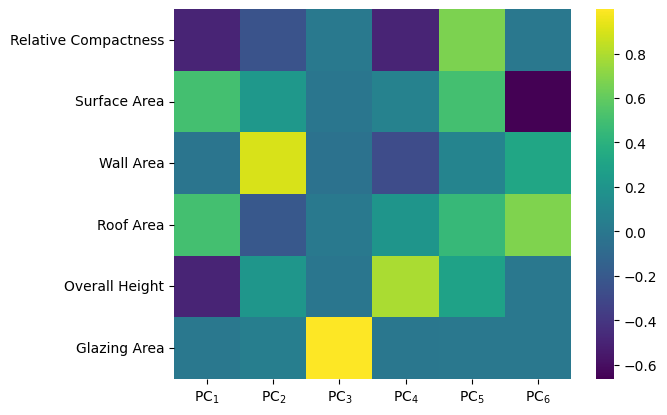

In [ ]:
import seaborn as sns

# Visualize correlations using PCA
# TODO: train a PCA model on the continuous variables with 6 principal components
pca = PCA(n_components=6).fit(X_train_continuous_scaled)
print(f"""
Number of principal components: {pca.n_components_}
Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}""")

# This snippet plot the principal components coordinates. What can you say about
# these principal components and the directions of highest variances?
variables_mapping = {
    "X1": "Relative Compactness",
    "X2": "Surface Area",
    "X3": "Wall Area",
    "X4": "Roof Area",
    "X5": "Overall Height",
    "X6": "Orientation",
    "X7": "Glazing Area",
    "X8": "Glazing Area Distribution",
}
variables = [variables_mapping[col] for col in X_continuous.columns]
sns.heatmap(pca.components_[:].T, cmap="viridis", yticklabels=variables, xticklabels=[f"PC$_{{{i + 1}}}$" for i in range(pca.n_components_)])

In [ ]:
# linear model on both datasets
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# TODO: train a linear regression without preprocessing the categorical features
# without one hot
lr1 = LinearRegression()
lr1.fit(X_train, y_train)
y_pred = lr1.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values") * 100
print(f"MAPE without one hot: heating_load={mape[0]:.2f}%, cooling_load={mape[1]:.2f}%")

# TODO: train a linear regressor using the one hot encoded categorical features
# with one hot
lr2 = LinearRegression()
lr2.fit(X_train_with_one_hot, y_train)
y_pred = lr2.predict(X_test_with_one_hot)
mape = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values") * 100
print(f"MAPE with one hot: heating_load={mape[0]:.2f}%, cooling_load={mape[1]:.2f}%")

# TODO: train a random forest regressors
# with RF
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values") * 100
print(f"MAPE with RF: heating_load={mape[0]:.2f}%, cooling_load={mape[1]:.2f}%")

# TODO: train a gradient boosting regressor. BE CAREFUL: scikit-learn class cannot
# regress on multiple outputs!
# with GBM
gbm1 = GradientBoostingRegressor()
gbm1.fit(X_train, y_train.iloc[:, 0])
gbm2 = GradientBoostingRegressor()
gbm2.fit(X_train, y_train.iloc[:, 1])
y_pred1 = gbm1.predict(X_test)
y_pred2 = gbm2.predict(X_test)
y_pred = np.stack([y_pred1, y_pred2], axis=1)
mape = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values") * 100
print(f"MAPE with GBM: heating_load={mape[0]:.2f}%, cooling_load={mape[1]:.2f}%")


MAPE without one hot: heating_load=10.11%, cooling_load=8.61%
MAPE with one hot: heating_load=9.43%, cooling_load=8.57%
MAPE with RF: heating_load=1.48%, cooling_load=3.53%
MAPE with GBM: heating_load=1.60%, cooling_load=3.59%


Text(0.5, 1.0, 'Feature importance')

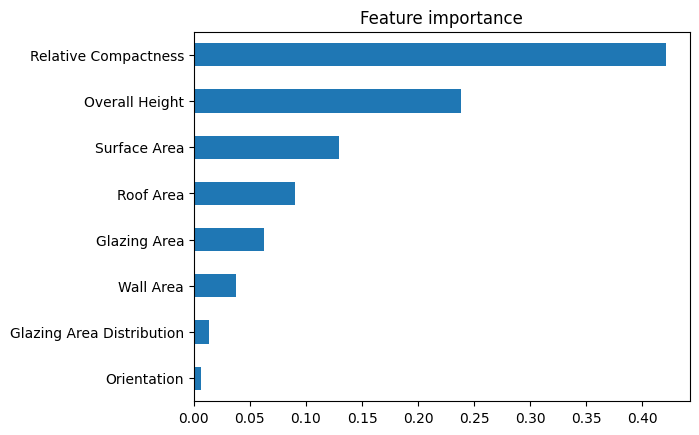

In [ ]:
# TODO: Plot feature importance. What do you see?
import pandas as pd
import matplotlib.pyplot as plt

columns = np.array(X_continuous.columns.tolist() + X_categorical.columns.tolist())
columns = np.array([variables_mapping[col] for col in columns])
idx = np.argsort(rf.feature_importances_)
pd.Series(rf.feature_importances_[idx], index=columns[idx]).plot(kind="barh")
plt.title("Feature importance")

Text(0.5, 1.0, 'Feature importance')

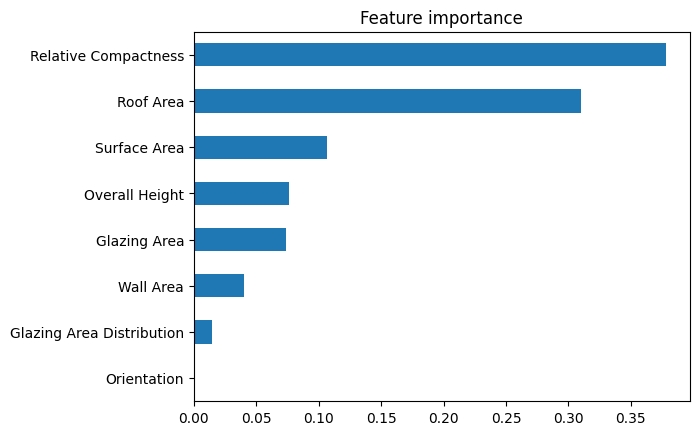

In [ ]:
# TODO: Plot feature importance. What do you see?
import pandas as pd
import matplotlib.pyplot as plt

columns = np.array(X_continuous.columns.tolist() + X_categorical.columns.tolist())
columns = np.array([variables_mapping[col] for col in columns])
idx = np.argsort(gbm1.feature_importances_)
pd.Series(gbm1.feature_importances_[idx], index=columns[idx]).plot(kind="barh")
plt.title("Feature importance")

Text(0.5, 1.0, 'Feature importance')

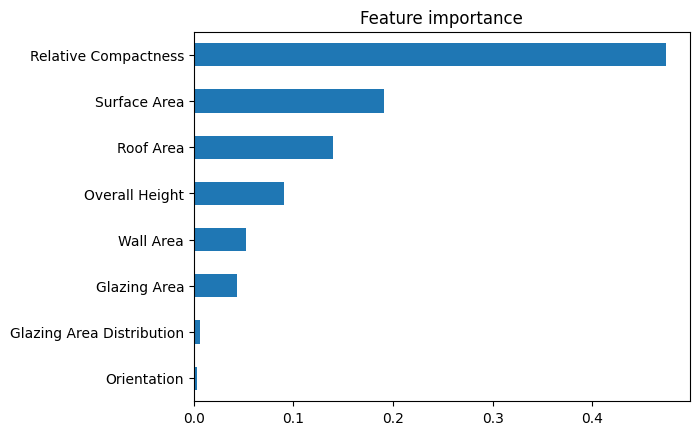

In [ ]:
# TODO: Plot feature importance. What do you see?
import pandas as pd
import matplotlib.pyplot as plt

columns = np.array(X_continuous.columns.tolist() + X_categorical.columns.tolist())
columns = np.array([variables_mapping[col] for col in columns])
idx = np.argsort(gbm2.feature_importances_)
pd.Series(gbm2.feature_importances_[idx], index=columns[idx]).plot(kind="barh")
plt.title("Feature importance")